# Cluster analysis

 by Thibaut Perol

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import json
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from pyquery import PyQuery as pq
import requests
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import random
import json
import time
import csv

#set default plot characterstics and colors
from matplotlib import rcParams

#dark_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
dark_colors = ["#99D699", "#B2B2B2",
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (12, 9)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = "white"
rcParams['axes.titlesize'] = 20      
rcParams['axes.labelsize'] = 17.5
rcParams['xtick.labelsize'] = 15 
rcParams['ytick.labelsize'] = 15
rcParams['legend.fontsize'] = 17.5
rcParams['patch.edgecolor'] = 'none'
rcParams['grid.color']="gray"   
rcParams['grid.linestyle']="-" 
rcParams['grid.linewidth'] = 0.3
rcParams['grid.alpha']=1
rcParams['text.color'] = "444444"
rcParams['axes.labelcolor'] = "444444"
rcParams['ytick.color'] = "444444"
rcParams['xtick.color'] = "444444"

# Load the data frame
eq_df = pd.DataFrame.from_csv('./tempdata/earthquakes_catalog.csv',sep = '|')

# Show the first 5 earthquakes in the catalog and their features
eq_df.head()


,id,origintime,latitude,longitude,depth,county,origin_src,prefmag,pmag_type,pmag_src,m3hz_ogs,md_ogs,geom,year_float
0,255,1980-01-05 07:11:31.21,35.586,-97.894,5,CANADIAN,OGS,1.9,M3Hz,OGS,1.9,1.7,0101000020E6100000F0A7C64B377958C05EBA490C02CB...,1980.130
1,256,1980-01-12 07:12:56.45,36.453,-97.642,5,GARFIELD,OGS,1.7,M3Hz,OGS,1.7,1.4,0101000020E61000000C022B87166958C0448B6CE7FB39...,1980.320
2,257,1980-02-03 00:46:30.05,33.994,-97.463,5,LOVE,OGS,2.2,M3Hz,OGS,2.2,2.0,0101000020E61000001283C0CAA15D58C0AC1C5A643BFF...,1980.920
3,258,1980-02-05 04:32:35.45,34.046,-97.451,5,LOVE,OGS,2.1,M3Hz,OGS,2.1,1.9,0101000020E6100000BE9F1A2FDD5C58C0D9CEF753E305...,1980.980
4,259,1980-03-09 03:57:10.56,35.100,-95.100,5,HASKELL,OGS,1.2,M3Hz,OGS,1.2,1.4,0101000020E61000006666666666C657C0CDCCCCCCCC8C...,1980.188


# Earthquake count versus time

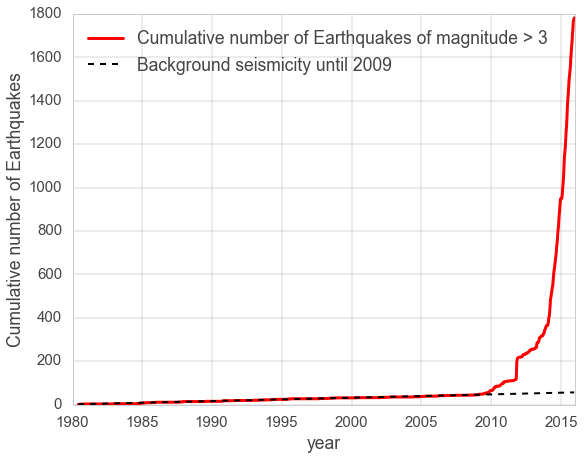

In [2]:
mask = eq_df['prefmag'] >=3
eq_count, base = np.histogram(eq_df[mask]['year_float'], bins = eq_df[mask].shape[0])
plt.figure(figsize = (9,7))
plt.plot(base[:-1], np.cumsum(eq_count), lw=3,c='r', label='Cumulative number of Earthquakes of magnitude > 3' )
mask_time = (eq_df['year_float'] < 2009) & (eq_df['prefmag'] >=3)
eq_2010, base_2010 = np.histogram(eq_df[mask_time]['year_float'], bins = eq_df[mask_time].shape[0])
# fit the earthquake count before 2009 with a 1st order polynomial
fit = np.polyfit(base_2010[:-1],np.cumsum(eq_2010),1)
fit_fn = np.poly1d(fit)
plt.plot(base[:-1],fit_fn(base[:-1]),'k--',label = 'Background seismicity until 2009')
plt.xlim([1980,2016]);
plt.ylabel('Cumulative number of Earthquakes')
plt.xlabel('year')
plt.legend(loc =2);

# Testing the DBSCAN algorithm


Here I am testing the DBSCAN clustering algorithm.


In [ ]:
# run this cell to choose a subset of the data

# define subset of data
# choose randomly half of the values
sample_size = since_1980_df.shape[0]
subset = since_1980_df.iloc[random.sample(since_1980_df.index,sample_size)]

## Choose the features

Now we want to apply the DBSCAN algorithm to our data. The features would be longitude, lattitude and depth.

In [131]:
# import libraries for DBSCAN
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

##############################################################################
# Compute DBSCAN
##############################################################################


centers = [[1, 1], [-1, -1], [1, -1]]
X_t = []

for (lat,longi,z) in zip(subset.latitude,subset.longitude,subset.depth):
    X_t.append([lat,longi,z])
np.array(X_t)
db = DBSCAN(min_samples=100).fit(X_t)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
# note that noise is when the label is -1
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)          

Estimated number of clusters: 3


## Plot

Plot the clusters on a map with longitude and latitude.

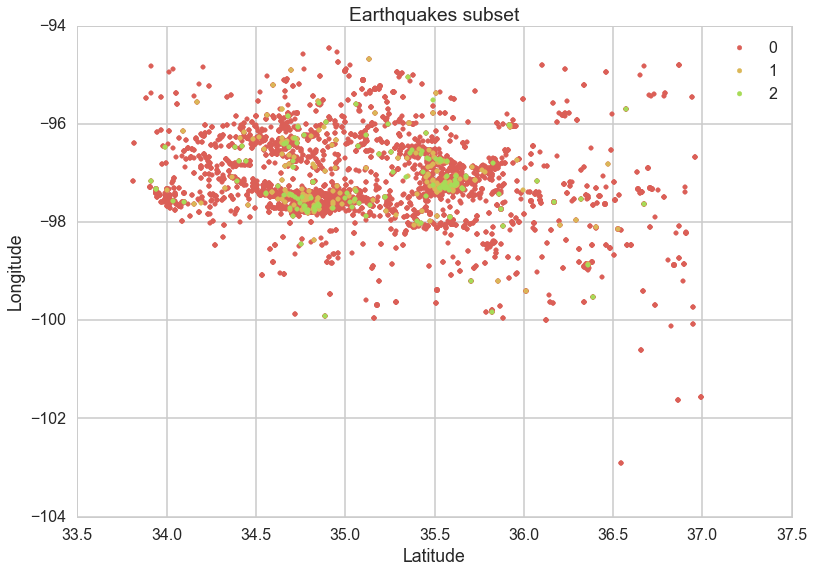

In [139]:
# get the set of labels
various_labels = set(labels)
sns.set_palette('husl')
for i in range(0,len(list(various_labels))):
    if list(various_labels)[i]!=-1:
        mask = db.labels_ == list(various_labels)[i]
        plt.scatter(subset.latitude[mask], subset.longitude[mask],label=list(various_labels)[i], color = sns.color_palette('hls',9)[i], alpha =1);
plt.xlabel('Latitude');
plt.ylabel('Longitude');
plt.title("Earthquakes subset");
plt.legend();